# Pytorch - фреймворк глубокого обучения

Две основные фичи, которые предоставляет Pytorch, это 
1. Тензорные вычисления, ускоряемые с помощью GPU
2. Система автоматического дифференцирования (autograd)  

Для построения систем автоматического дифференцирование всегда требуется построение графа вычислений.  
Две наиболее популярные библиотеки в этой области, Pytorch и Tensorflow, отличаются подходом к конструированию этого графа
* В Tensorflow это происходит статически
* В Pytorch - динамически

Динамическое конструирование графа позволят разрабатывать Pytorch-приложения придерживаясь философии ООП, 
когда как в Tensorflow рано или поздно возникают некрасивые стыки функционального программирования и всем привычных классов. 
Писать проще на Pytorch, отлаживать модели и искать логические ошибки проще на Tensorflow.

### Для работы с данными Pytorch предоставляет две конструкции

**torch.utils.data.Dataset** - сам набор данных, в котором хранятся сэмплы и соотв. им разметка, которая зависит от типа решаемой задачи  
**torch.utils.data.DataLoader** - группирует данные, и предоставляет инструменты для обхода датасета

In [1]:
import torch                                  # сама библиотека
from torch import nn                          # в этом модуле находится основные строительные блоки для сборки нейросети
from torch.utils.data import DataLoader       # Dataloader - класс, отвечающий за разбиение данных на небольшие блоки-батчи
from torchvision import datasets              # datasets - это модуль, содержащие некоторые широко известные в ML наборы данных

Разработчики PyTorch параллельно ведут разработку библиотек для работы со специфичными данными -  TorchText, TorchVision, and TorchAudio  
В каждой из них есть собственные наборы данных. Мы будем использовать FashionMNIST, в состав которого входят изображения одежды небольшого разрешения,  
разбитые на 10 классов. 

In [2]:
from torchvision.transforms import ToTensor 

# Download training data from open datasets.
training_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())

# Download test data from open datasets.
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [3]:
type(training_data)

torchvision.datasets.mnist.FashionMNIST

##### Проиллюстрируем содержимое датасета

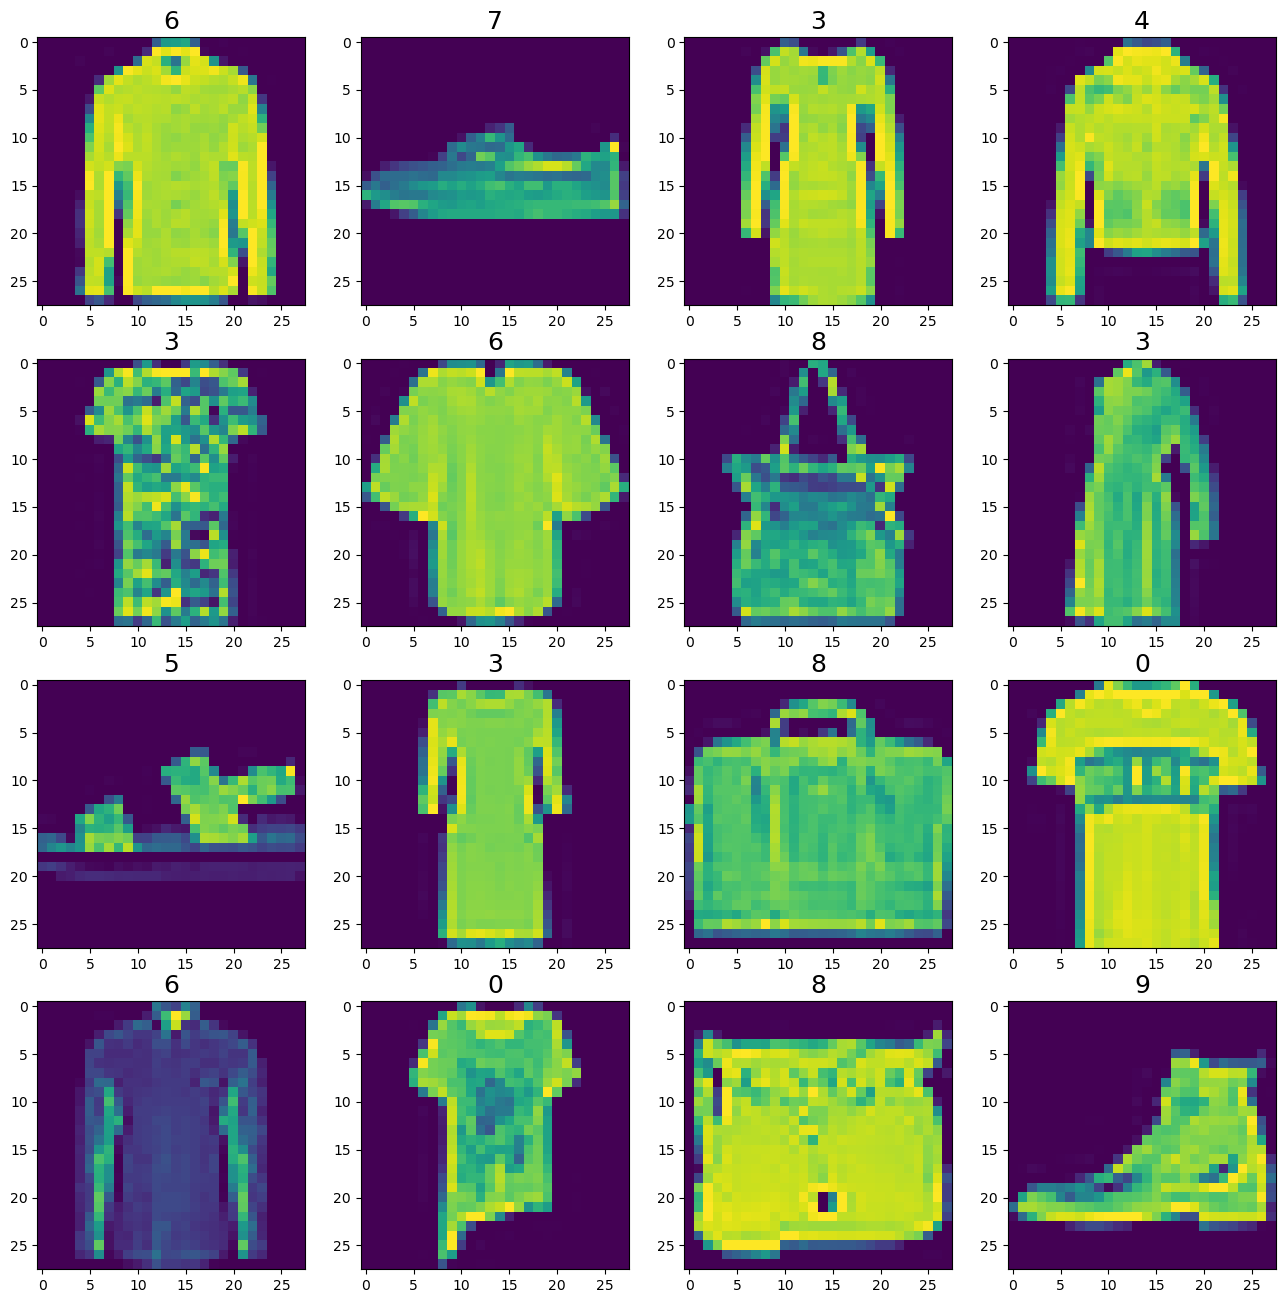

In [4]:
import numpy as np
import matplotlib.pyplot as plt

idx     = np.random.permutation(np.arange(len(training_data)))[:16]
samples = [training_data[i] for i in idx]

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for j, item in enumerate(samples):
    axes[j//4, j%4].imshow(item[0][0])
    axes[j//4, j%4].set_title(str(item[1]), fontsize=18)

##### Создадим загрузчики данных

In [5]:
batch_size = 64 # параметр batch_size отвечает за размер блоков, на которые мы разбиваем данные

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader  = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Как видим, стандартные загрузчики склеивают наши данные относительно новой оси, которая становится главной осью результирующего тензора

##### Соберем собственную нейросеть

In [6]:
# параметр device определяет то, где хранятся тензоры-"веса" нейросети

device = "cuda" if torch.cuda.is_available() else "cpu" 
print(f"Using {device} device")

Using cuda device


In [7]:
# для того, чтобы нейросеть поддерживалась моделью автоматического дифференцирования Pytorch
# каждый из ее структурных блоков должен наследоваться от класса nn.Module

class NeuralNetwork(nn.Module):
    
    def __init__(self):
        """
        В методе __init__ мы определеяем стурктуру нейросети 
        Наша будет представлять последовательность 3-х линейных слоев,
        в комбинации с нелинейной функцией активации ReLU
        
        """
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        """
        Метод Forward определят последовательность, в которой данные проходят через нейросеть
        """
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


##### Функция потерь и оптимизатор

In [8]:
# функция потерь должна быть либо дифференцируема средствами библиотеки
# либо вы должны сами предоставить ее градиент 
# стандартный выбор для задачи классификации - кросс-энтропия
loss_fn   = nn.CrossEntropyLoss()

# Воспользуемся весьма универсальным алгоритмом оптимизации Adam
# параметр lr, или learning rate - тот самый шаг оптимизации, который, зачастую, требуется подбирать вручную
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

##### Обучение и валидация

In [9]:
# Переключение моделей между режимами train и eval 
# 1. меняет поведение некоторых слоев
# 2. отключает накопление градиента
# В данном случае поведение меняться не будет, однако на памяти мы сэкономим

def train(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

##### Запустим процесс обучения модели на 10 эпох - полных итераций по датасетам

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.314607  [    0/60000]
loss: 0.801777  [ 6400/60000]
loss: 0.442309  [12800/60000]
loss: 0.619290  [19200/60000]
loss: 0.519776  [25600/60000]
loss: 0.465220  [32000/60000]
loss: 0.437299  [38400/60000]
loss: 0.598917  [44800/60000]
loss: 0.520639  [51200/60000]
loss: 0.502670  [57600/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.447538 

Epoch 2
-------------------------------
loss: 0.298609  [    0/60000]
loss: 0.390108  [ 6400/60000]
loss: 0.302001  [12800/60000]
loss: 0.449431  [19200/60000]
loss: 0.413735  [25600/60000]
loss: 0.376417  [32000/60000]
loss: 0.355633  [38400/60000]
loss: 0.534067  [44800/60000]
loss: 0.462867  [51200/60000]
loss: 0.489111  [57600/60000]
Test Error: 
 Accuracy: 85.5%, Avg loss: 0.401519 

Epoch 3
-------------------------------
loss: 0.231326  [    0/60000]
loss: 0.316710  [ 6400/60000]
loss: 0.252165  [12800/60000]
loss: 0.366412  [19200/60000]
loss: 0.334107  [25600/60000]
loss: 0.349964  [32000/600

##### Pytorch предоставляет собственный механизм сохранения и загрузки обученных моделей

In [12]:
# сохраним текущую модель
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
# создадим новую, и загрузим в нее веса старой модели
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

##### Наконец, используем модель по назначению - будем предсказыывать классы, к которым принадлежит одежда

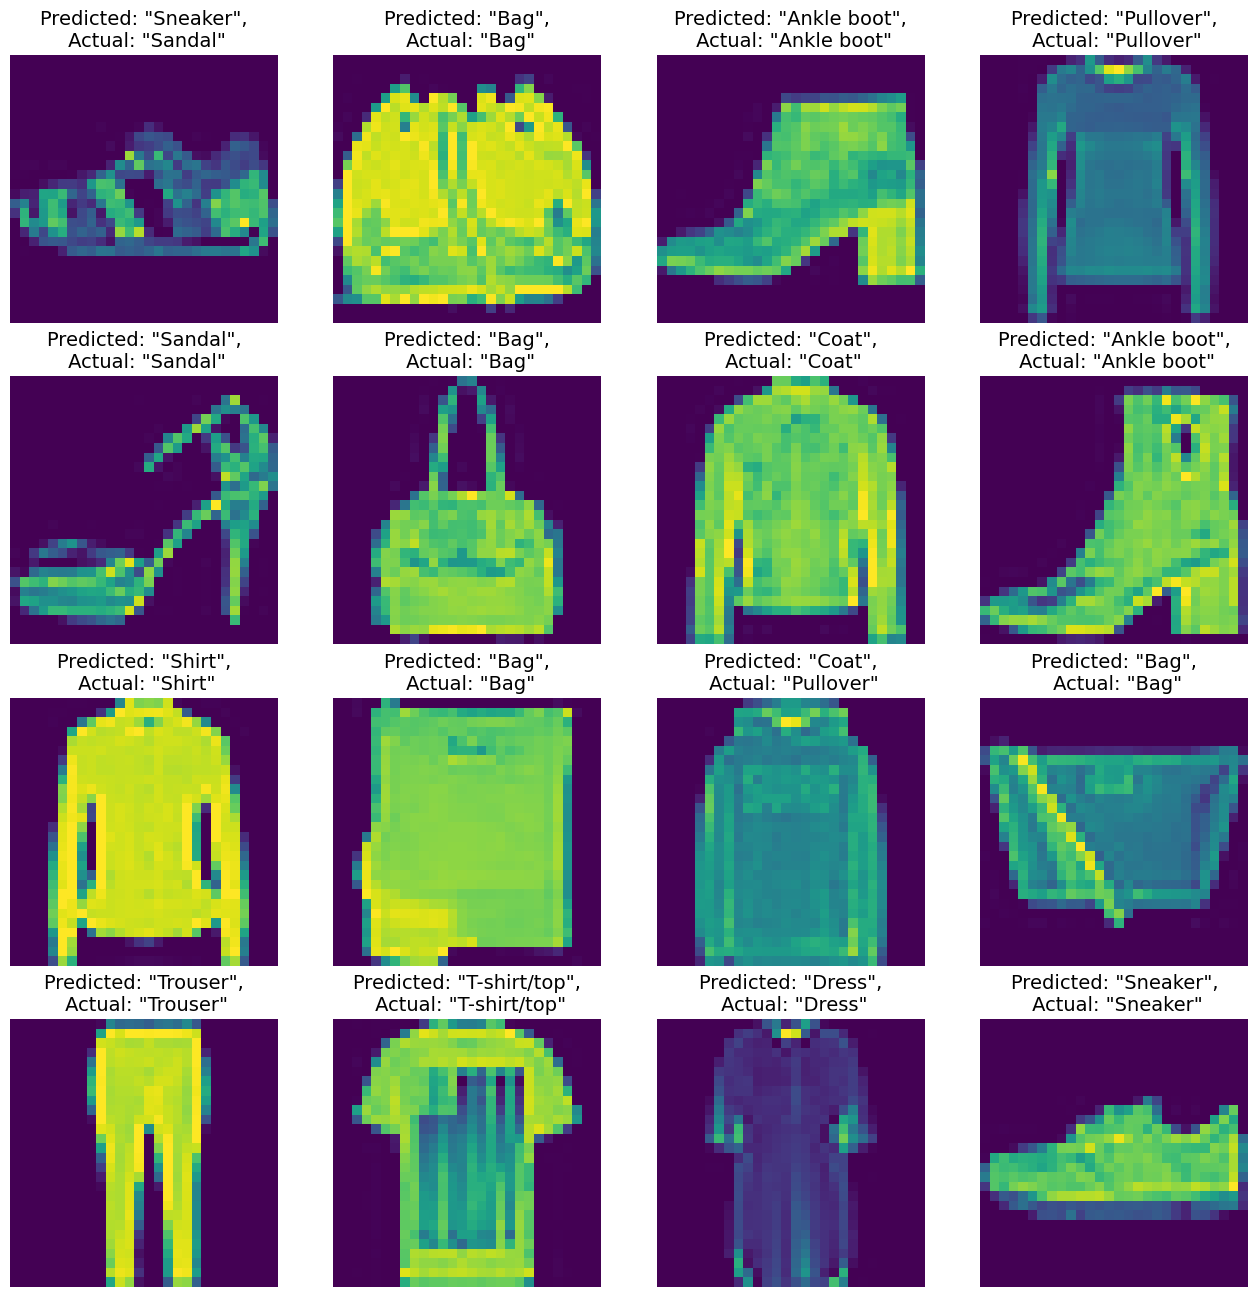

In [27]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()

idx     = np.random.permutation(np.arange(len(test_data)))[:16]
samples = [test_data[i] for i in idx]

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
for j, item in enumerate(samples):    
    
    predicted = classes[model(item[0]).argmax(1).item()]
    actual    = classes[item[1]]
    axes[j//4, j%4].imshow(item[0][0])    
    axes[j//4, j%4].set_title(f'Predicted: "{predicted}",\n Actual: "{actual}"', fontsize=14)
    axes[j//4, j%4].axis('off')

